   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 117.9 MB/s eta 0:00:00m eta 0:00:010:01


2025-04-29 10:09:56.318437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745935796.403691  208547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745935796.430335  208547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745935796.611229  208547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745935796.611249  208547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745935796.611252  208547 computation_placer.cc:177] computation placer alr

Loading Phi-3 with LoRA...


tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/irtizahasan/anaconda3/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
You are not running the flash-attention implementation, expect numerical differences.


trainable params: 1,572,864 || all params: 3,822,652,416 || trainable%: 0.0411
Fine-tuning (LoRA)...


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Fine-tuning Epoch 1/5 — Avg Loss: 0.206241
Fine-tuning Epoch 2/5 — Avg Loss: 0.180911
Fine-tuning Epoch 3/5 — Avg Loss: 0.179315
Fine-tuning Epoch 4/5 — Avg Loss: 0.177498
Fine-tuning Epoch 5/5 — Avg Loss: 0.176691


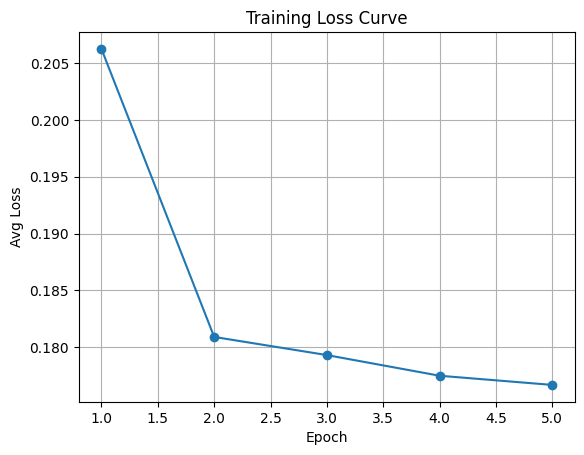

Testing...


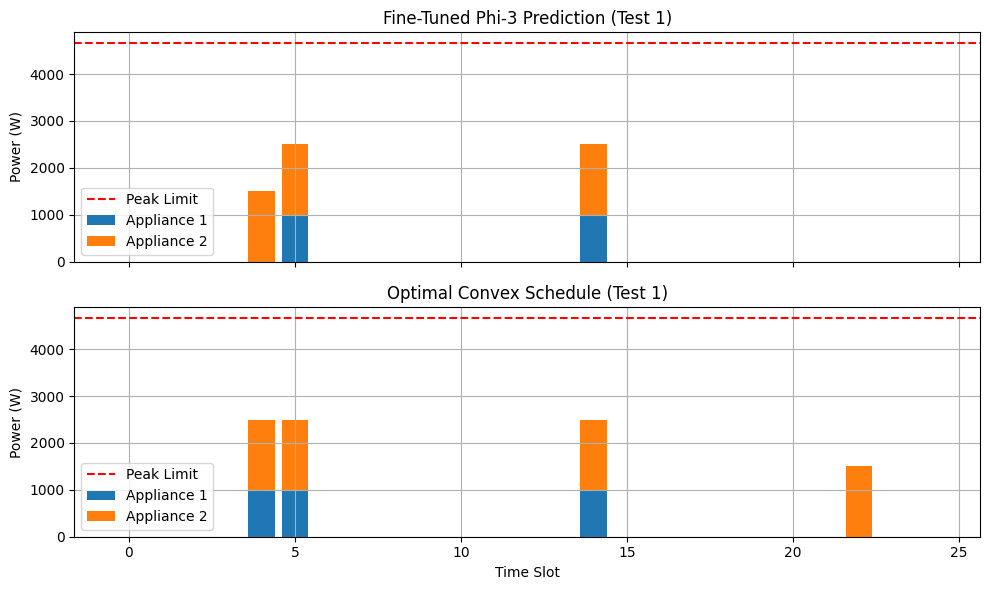

Test 1: Predicted Cost = $0.44 | Optimal Cost = $0.63 | Gap = $-0.20


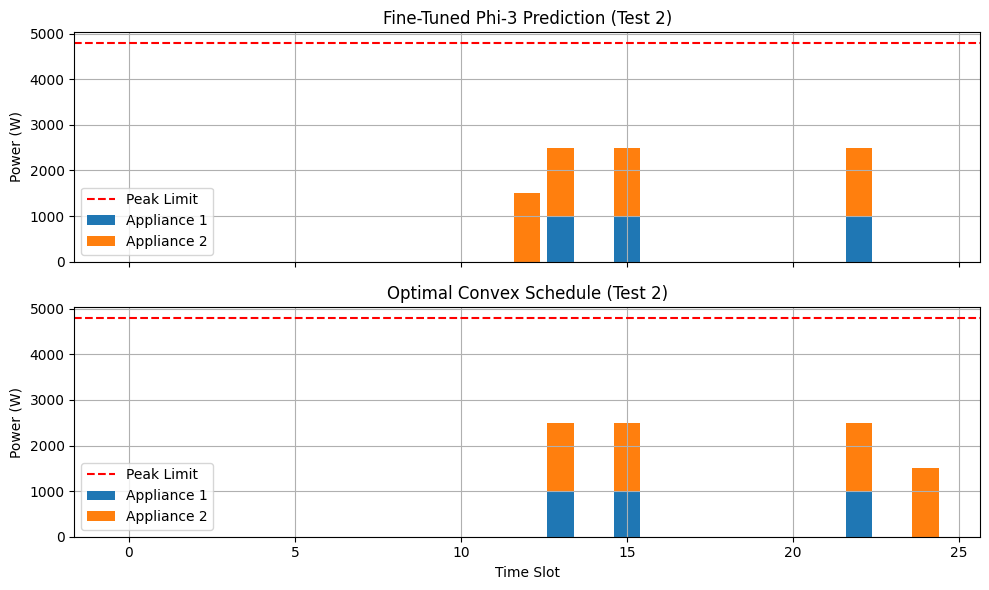

Test 2: Predicted Cost = $0.57 | Optimal Cost = $0.55 | Gap = $0.02


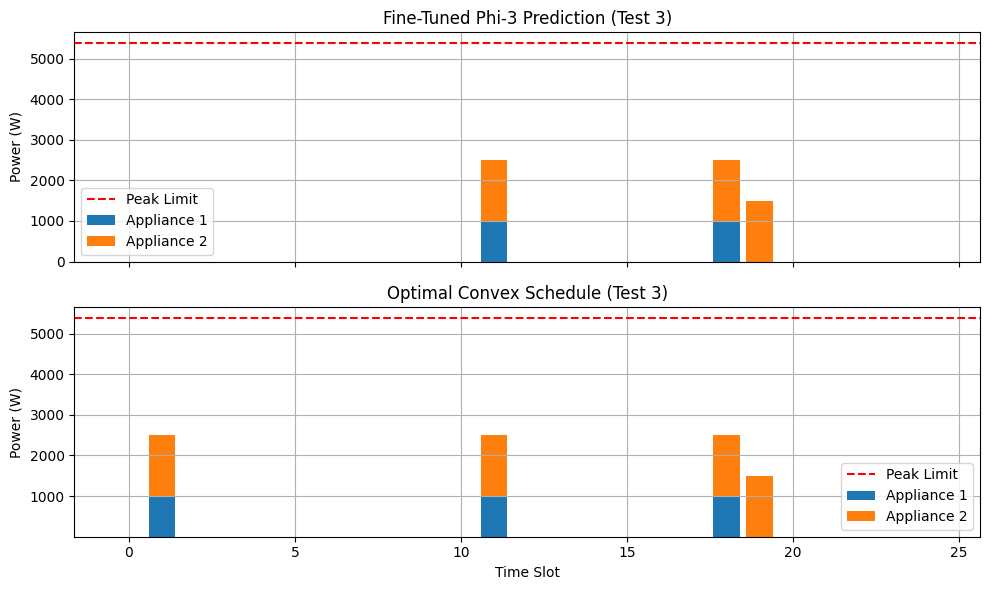

Test 3: Predicted Cost = $0.39 | Optimal Cost = $0.56 | Gap = $-0.16


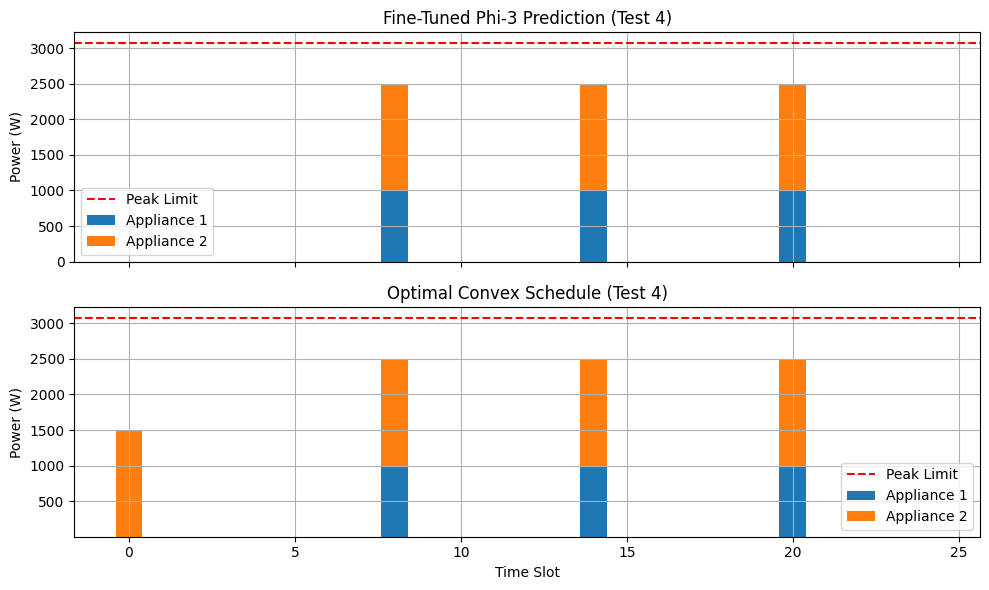

Test 4: Predicted Cost = $0.44 | Optimal Cost = $0.53 | Gap = $-0.10


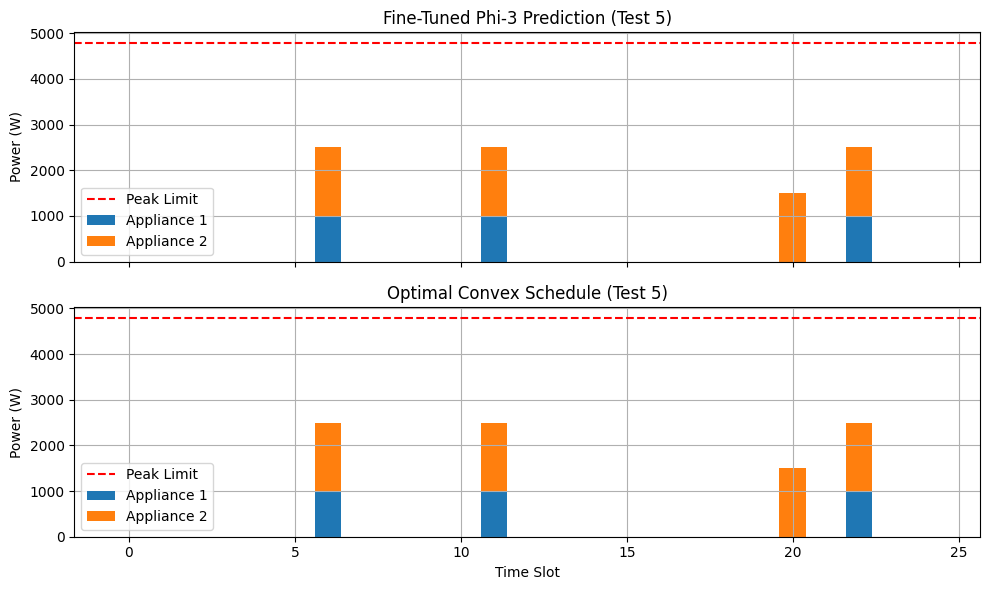

Test 5: Predicted Cost = $0.53 | Optimal Cost = $0.53 | Gap = $-0.00


In [ ]:
# Install everything
!pip install transformers bitsandbytes peft torch cvxpy numpy matplotlib tabulate

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import re
from tabulate import tabulate

torch.cuda.empty_cache()

# 1) Convex Oracle
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    return X.value.astype(float)

# 2) Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])
        self.E_h = np.array([3000, 6000])
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, self.E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, self.E_h), start=1):
            s += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide only a {self.N}x{self.H} matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Phi Model with LoRA
class PhiScheduler:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
            trust_remote_code=True
        )

        model = prepare_model_for_kbit_training(model)

        lora_config = LoraConfig(
            r=8,
            lora_alpha=16,
            target_modules=["k_proj", "q_proj", "v_proj", "o_proj"],  # correct names for Phi-3
            lora_dropout=0.05,
            bias="none",
            task_type=TaskType.CAUSAL_LM,
        )

        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        self.model = model
        self.model.eval()
        self.N = None
        self.H = None

    def fine_tune(self, dataset, epochs=1, batch_size=1, lr=2e-4):
        self.model.train()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_history = []

        for ep in range(1, epochs+1):
            running_loss = 0.0
            for prompts, targets in loader:
                full_texts = []
                for prompt, target in zip(prompts, targets):
                    schedule_text = ";".join(",".join(f"{v:.1f}" for v in target.reshape(self.N, self.H)[i]) for i in range(self.N))
                    full_prompt = prompt + "\n\n" + schedule_text
                    full_texts.append(full_prompt)

                encodings = self.tokenizer(full_texts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
                outputs = self.model(**encodings, labels=encodings["input_ids"])
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * len(prompts)

            avg_loss = running_loss / len(dataset)
            loss_history.append(avg_loss)
            print(f"Fine-tuning Epoch {ep}/{epochs} — Avg Loss: {avg_loss:.6f}")

        self.model.eval()

        # Plot Loss Curve
        plt.plot(range(1, epochs+1), loss_history, marker='o')
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Avg Loss')
        plt.grid(True)
        plt.show()

        return self

    def generate_schedule(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=500, do_sample=False)
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

# 4) Parse output
def parse_phi_output(output, N, H):
    try:
        matrix_str = re.findall(r"(\d\.\d,\d\.\d;)", output)
        if not matrix_str or len(matrix_str) < N:
            raise ValueError("Not enough matrix rows parsed.")
        schedule = np.zeros((N, H))
        for i, entry in enumerate(matrix_str[:N]):
            values = entry.strip(';').split(',')
            schedule[i] = [float(v) for v in values]
        return np.clip(schedule, 0, 1)
    except Exception as e:
        print(f"Parsing error: {e}. Using zeros.")
        return np.zeros((N, H))

def test_and_plot(model, tests=5, N=25, H=2):
    import matplotlib.pyplot as plt
    import numpy as np
    import re

    P_h = np.array([1000, 1500])
    E_h = np.array([3000, 6000])

    tokenizer = model.tokenizer
    model = model.model
    model.eval()

    def parse_output(output, N, H):
        try:
            matrix_str = re.findall(r"(\d\.\d,\d\.\d;)", output)
            if not matrix_str or len(matrix_str) < N:
                raise ValueError("Not enough matrix rows parsed.")
            schedule = np.zeros((N, H))
            for i, entry in enumerate(matrix_str[:N]):
                values = entry.strip(';').split(',')
                schedule[i] = [float(v) for v in values]
            return np.clip(schedule, 0, 1)
        except Exception as e:
            print(f"Parsing error: {e}. Using zeros.")
            return np.zeros((N, H))

    for t_i in range(1, tests + 1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        peak = np.random.randint(2000, 6000)

        # Build Prompt
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide only a {N}x{H} matrix."

        # Tokenize
        inputs = tokenizer(p, return_tensors="pt").to(model.device)

        # Fix for Phi-3 generation
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            use_cache=False,   # important fix
            do_sample=False
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Parse prediction
        pred_sched = parse_output(generated_text, N, H)

        # Solve optimal
        X = cp.Variable((N, H))
        power = cp.multiply(X, P_h.reshape(1, H))
        cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
        constraints = [
            cp.sum(power, axis=0) >= E_h,
            cp.sum(power, axis=1) <= peak,
            X >= 0, X <= 1
        ]
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve()
        opt_sched = X.value

        # Compute Costs
        cost_pred = (price[:, None] * (pred_sched * P_h) / 1000.0).sum()
        cost_opt = (price[:, None] * (opt_sched * P_h) / 1000.0).sum()

        # Plot
        t = np.arange(N)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

        ax1.bar(t, pred_sched[:,0]*P_h[0], label="Appliance 1")
        ax1.bar(t, pred_sched[:,1]*P_h[1], bottom=pred_sched[:,0]*P_h[0], label="Appliance 2")
        ax1.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax1.set_title(f"Fine-Tuned Phi-3 Prediction (Test {t_i})")
        ax1.set_ylabel("Power (W)")
        ax1.legend()
        ax1.grid(True)

        ax2.bar(t, opt_sched[:,0]*P_h[0], label="Appliance 1")
        ax2.bar(t, opt_sched[:,1]*P_h[1], bottom=opt_sched[:,0]*P_h[0], label="Appliance 2")
        ax2.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax2.set_title(f"Optimal Convex Schedule (Test {t_i})")
        ax2.set_xlabel("Time Slot")
        ax2.set_ylabel("Power (W)")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"Test {t_i}: Predicted Cost = ${cost_pred:.2f} | Optimal Cost = ${cost_opt:.2f} | Gap = ${cost_pred-cost_opt:.2f}")


# 6) Main
if __name__ == "__main__":
    N, H = 25, 2
    ds = TSLSupervisedDatasetStructured(300, N, H)  # Smaller dataset to fit memory
    print("Loading Phi-3 with LoRA...")
    model = PhiScheduler()
    model.N, model.H = N, H

    print("Fine-tuning (LoRA)...")
    model = model.fine_tune(ds, epochs=5, batch_size=1, lr=2e-4)

    print("Testing...")
    test_and_plot(model, tests=5, N=N, H=H)


Preparing Phi-3 scheduler...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 1,572,864 || all params: 3,822,652,416 || trainable%: 0.0411
Fine-tuning LoRA adapter...


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch 1/5 — Avg Loss: 0.206274
Epoch 2/5 — Avg Loss: 0.181097
Epoch 3/5 — Avg Loss: 0.178721
Epoch 4/5 — Avg Loss: 0.179107
Epoch 5/5 — Avg Loss: 0.177198


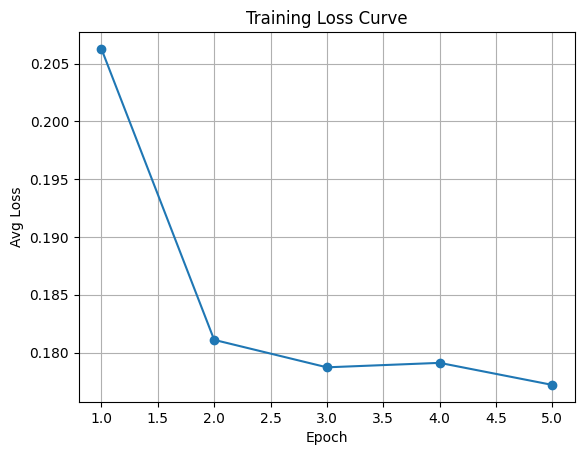

Saved to ./phi3_lora_finetuned
Packaged to ./phi3_lora_finetuned.zip

===== Prompt =====
[Prices]
Slot 1: 0.097 $/kWh
Slot 2: 0.055 $/kWh
Slot 3: 0.197 $/kWh
Slot 4: 0.072 $/kWh
Slot 5: 0.100 $/kWh
Slot 6: 0.193 $/kWh
Slot 7: 0.062 $/kWh
Slot 8: 0.132 $/kWh
Slot 9: 0.060 $/kWh
Slot 10: 0.156 $/kWh
Slot 11: 0.113 $/kWh
Slot 12: 0.182 $/kWh
Slot 13: 0.191 $/kWh
Slot 14: 0.167 $/kWh
Slot 15: 0.127 $/kWh
Slot 16: 0.102 $/kWh
Slot 17: 0.115 $/kWh
Slot 18: 0.151 $/kWh
Slot 19: 0.188 $/kWh
Slot 20: 0.159 $/kWh
Slot 21: 0.155 $/kWh
Slot 22: 0.109 $/kWh
Slot 23: 0.134 $/kWh
Slot 24: 0.180 $/kWh
Slot 25: 0.065 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
3.5 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix.

===== LLM Response =====
[Prices]
Slot 1: 0.097 $/kWh
Slot 2: 0.055 $/kWh
Slot 3: 0.197 $/kWh
Slot 4: 0.072 $/kWh
Slot 5: 0.100 $/kWh
Slot 6: 

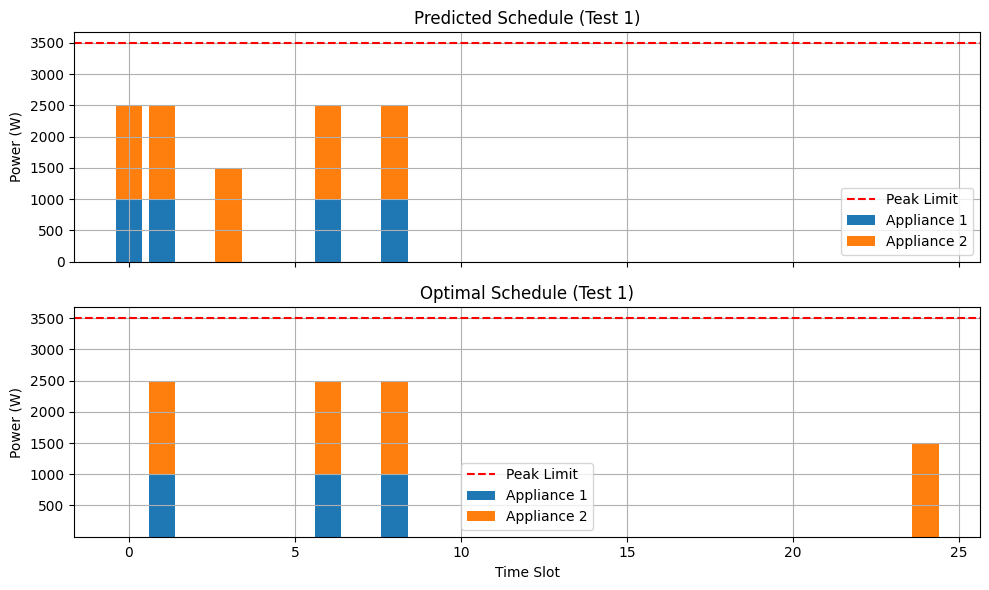

Test 1: Pred Cost=$0.79 | Opt Cost=$0.54 | Gap=$0.25


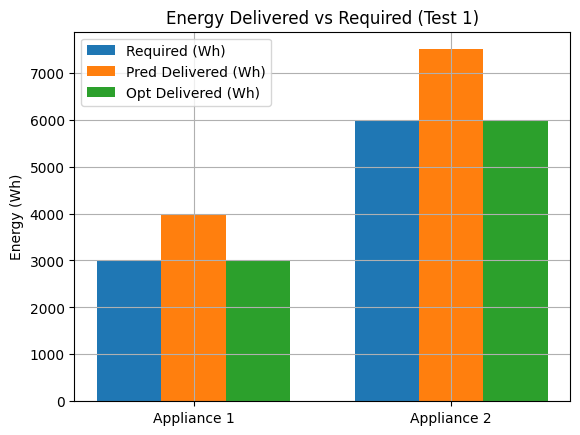


===== Prompt =====
[Prices]
Slot 1: 0.184 $/kWh
Slot 2: 0.100 $/kWh
Slot 3: 0.134 $/kWh
Slot 4: 0.165 $/kWh
Slot 5: 0.107 $/kWh
Slot 6: 0.189 $/kWh
Slot 7: 0.175 $/kWh
Slot 8: 0.059 $/kWh
Slot 9: 0.078 $/kWh
Slot 10: 0.194 $/kWh
Slot 11: 0.162 $/kWh
Slot 12: 0.090 $/kWh
Slot 13: 0.072 $/kWh
Slot 14: 0.180 $/kWh
Slot 15: 0.130 $/kWh
Slot 16: 0.086 $/kWh
Slot 17: 0.094 $/kWh
Slot 18: 0.063 $/kWh
Slot 19: 0.090 $/kWh
Slot 20: 0.175 $/kWh
Slot 21: 0.063 $/kWh
Slot 22: 0.166 $/kWh
Slot 23: 0.101 $/kWh
Slot 24: 0.124 $/kWh
Slot 25: 0.154 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
3.7 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix.


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



===== LLM Response =====
[Prices]
Slot 1: 0.184 $/kWh
Slot 2: 0.100 $/kWh
Slot 3: 0.134 $/kWh
Slot 4: 0.165 $/kWh
Slot 5: 0.107 $/kWh
Slot 6: 0.189 $/kWh
Slot 7: 0.175 $/kWh
Slot 8: 0.059 $/kWh
Slot 9: 0.078 $/kWh
Slot 10: 0.194 $/kWh
Slot 11: 0.162 $/kWh
Slot 12: 0.090 $/kWh
Slot 13: 0.072 $/kWh
Slot 14: 0.180 $/kWh
Slot 15: 0.130 $/kWh
Slot 16: 0.086 $/kWh
Slot 17: 0.094 $/kWh
Slot 18: 0.063 $/kWh
Slot 19: 0.090 $/kWh
Slot 20: 0.175 $/kWh
Slot 21: 0.063 $/kWh
Slot 22: 0.166 $/kWh
Slot 23: 0.101 $/kWh
Slot 24: 0.124 $/kWh
Slot 25: 0.154 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
3.7 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons.

0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;1.0,1.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,1.0;0.0,0.0;0.0,0.0;0.0,

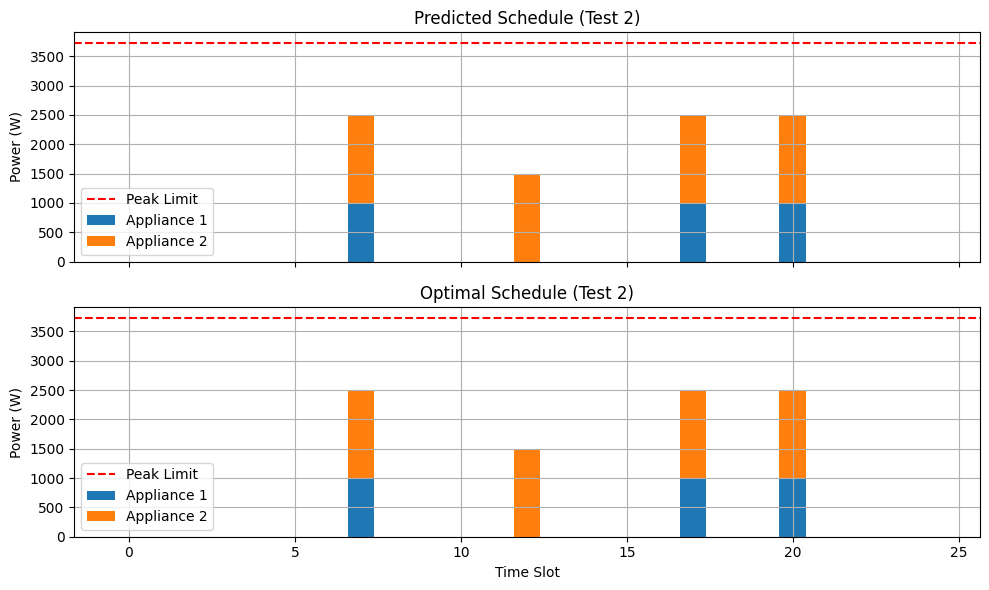

Test 2: Pred Cost=$0.57 | Opt Cost=$0.57 | Gap=$-0.00


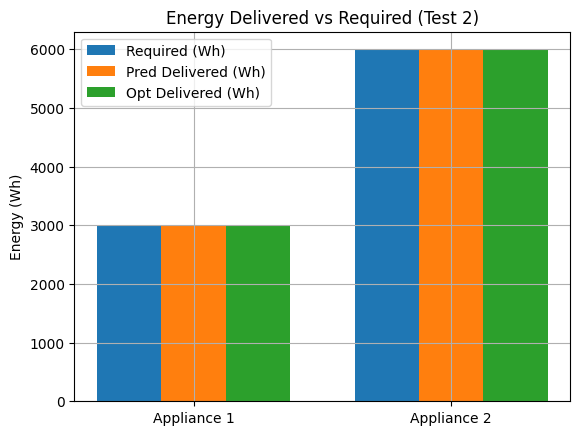


===== Prompt =====
[Prices]
Slot 1: 0.134 $/kWh
Slot 2: 0.175 $/kWh
Slot 3: 0.067 $/kWh
Slot 4: 0.063 $/kWh
Slot 5: 0.053 $/kWh
Slot 6: 0.176 $/kWh
Slot 7: 0.134 $/kWh
Slot 8: 0.138 $/kWh
Slot 9: 0.156 $/kWh
Slot 10: 0.129 $/kWh
Slot 11: 0.128 $/kWh
Slot 12: 0.091 $/kWh
Slot 13: 0.112 $/kWh
Slot 14: 0.138 $/kWh
Slot 15: 0.163 $/kWh
Slot 16: 0.110 $/kWh
Slot 17: 0.121 $/kWh
Slot 18: 0.175 $/kWh
Slot 19: 0.052 $/kWh
Slot 20: 0.051 $/kWh
Slot 21: 0.086 $/kWh
Slot 22: 0.156 $/kWh
Slot 23: 0.100 $/kWh
Slot 24: 0.177 $/kWh
Slot 25: 0.107 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
4.0 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix.


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



===== LLM Response =====
[Prices]
Slot 1: 0.134 $/kWh
Slot 2: 0.175 $/kWh
Slot 3: 0.067 $/kWh
Slot 4: 0.063 $/kWh
Slot 5: 0.053 $/kWh
Slot 6: 0.176 $/kWh
Slot 7: 0.134 $/kWh
Slot 8: 0.138 $/kWh
Slot 9: 0.156 $/kWh
Slot 10: 0.129 $/kWh
Slot 11: 0.128 $/kWh
Slot 12: 0.091 $/kWh
Slot 13: 0.112 $/kWh
Slot 14: 0.138 $/kWh
Slot 15: 0.163 $/kWh
Slot 16: 0.110 $/kWh
Slot 17: 0.121 $/kWh
Slot 18: 0.175 $/kWh
Slot 19: 0.052 $/kWh
Slot 20: 0.051 $/kWh
Slot 21: 0.086 $/kWh
Slot 22: 0.156 $/kWh
Slot 23: 0.100 $/kWh
Slot 24: 0.177 $/kWh
Slot 25: 0.107 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
4.0 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons.

0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;1.0,1.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,

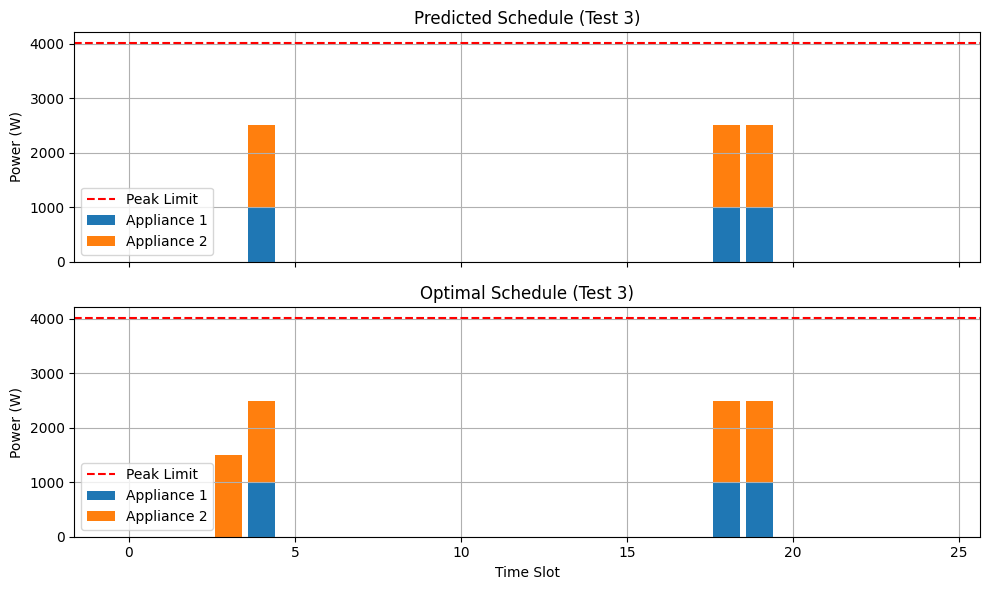

Test 3: Pred Cost=$0.39 | Opt Cost=$0.48 | Gap=$-0.09


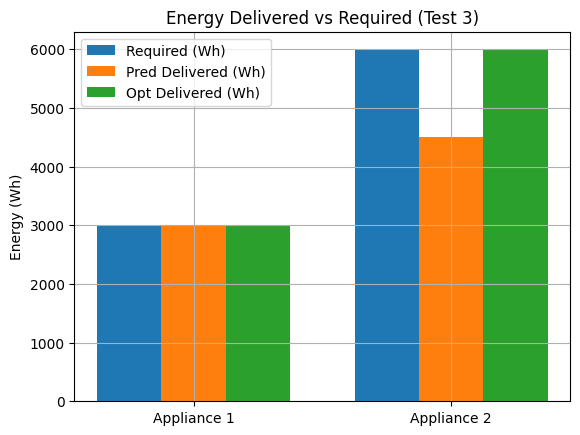


===== Prompt =====
[Prices]
Slot 1: 0.106 $/kWh
Slot 2: 0.052 $/kWh
Slot 3: 0.146 $/kWh
Slot 4: 0.077 $/kWh
Slot 5: 0.055 $/kWh
Slot 6: 0.189 $/kWh
Slot 7: 0.095 $/kWh
Slot 8: 0.140 $/kWh
Slot 9: 0.197 $/kWh
Slot 10: 0.084 $/kWh
Slot 11: 0.167 $/kWh
Slot 12: 0.109 $/kWh
Slot 13: 0.119 $/kWh
Slot 14: 0.113 $/kWh
Slot 15: 0.190 $/kWh
Slot 16: 0.150 $/kWh
Slot 17: 0.113 $/kWh
Slot 18: 0.118 $/kWh
Slot 19: 0.119 $/kWh
Slot 20: 0.107 $/kWh
Slot 21: 0.139 $/kWh
Slot 22: 0.095 $/kWh
Slot 23: 0.085 $/kWh
Slot 24: 0.186 $/kWh
Slot 25: 0.179 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
3.7 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix.


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



===== LLM Response =====
[Prices]
Slot 1: 0.106 $/kWh
Slot 2: 0.052 $/kWh
Slot 3: 0.146 $/kWh
Slot 4: 0.077 $/kWh
Slot 5: 0.055 $/kWh
Slot 6: 0.189 $/kWh
Slot 7: 0.095 $/kWh
Slot 8: 0.140 $/kWh
Slot 9: 0.197 $/kWh
Slot 10: 0.084 $/kWh
Slot 11: 0.167 $/kWh
Slot 12: 0.109 $/kWh
Slot 13: 0.119 $/kWh
Slot 14: 0.113 $/kWh
Slot 15: 0.190 $/kWh
Slot 16: 0.150 $/kWh
Slot 17: 0.113 $/kWh
Slot 18: 0.118 $/kWh
Slot 19: 0.119 $/kWh
Slot 20: 0.107 $/kWh
Slot 21: 0.139 $/kWh
Slot 22: 0.095 $/kWh
Slot 23: 0.085 $/kWh
Slot 24: 0.186 $/kWh
Slot 25: 0.179 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
3.7 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons.

0.0,0.0;1.0,1.0;0.0,0.0;0.0,0.0;1.0,1.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,

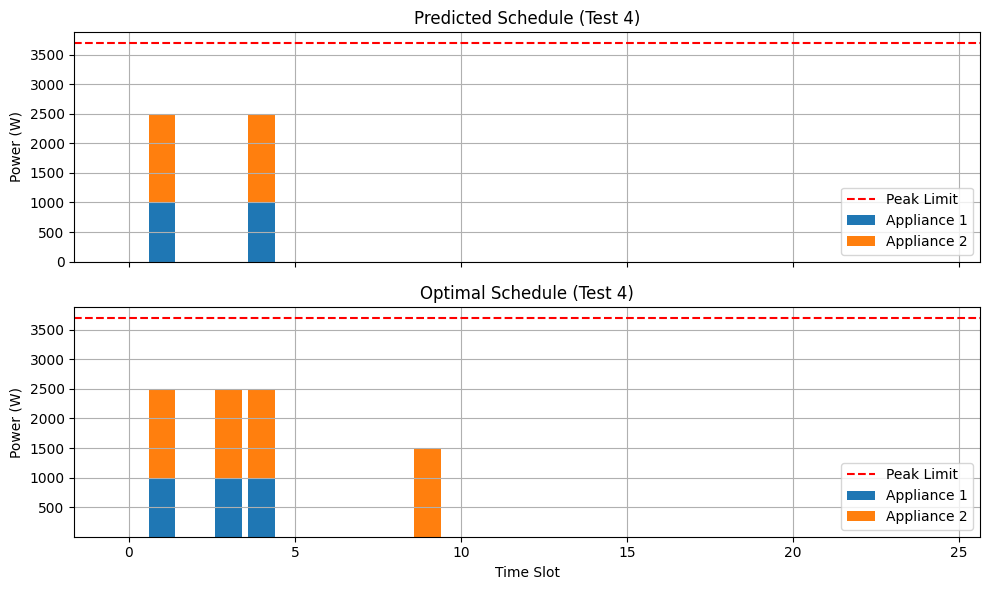

Test 4: Pred Cost=$0.27 | Opt Cost=$0.58 | Gap=$-0.32


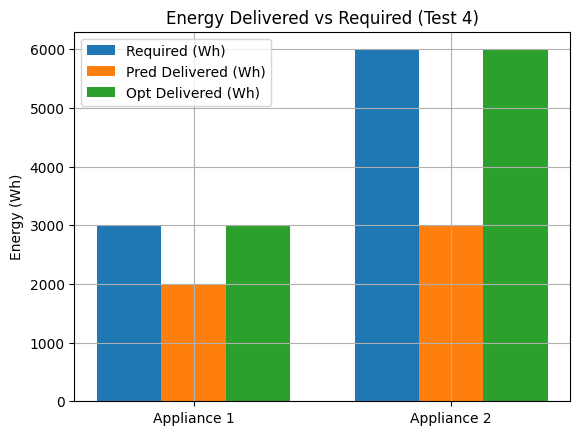


===== Prompt =====
[Prices]
Slot 1: 0.113 $/kWh
Slot 2: 0.192 $/kWh
Slot 3: 0.175 $/kWh
Slot 4: 0.170 $/kWh
Slot 5: 0.079 $/kWh
Slot 6: 0.143 $/kWh
Slot 7: 0.052 $/kWh
Slot 8: 0.109 $/kWh
Slot 9: 0.181 $/kWh
Slot 10: 0.196 $/kWh
Slot 11: 0.165 $/kWh
Slot 12: 0.119 $/kWh
Slot 13: 0.136 $/kWh
Slot 14: 0.088 $/kWh
Slot 15: 0.099 $/kWh
Slot 16: 0.139 $/kWh
Slot 17: 0.146 $/kWh
Slot 18: 0.069 $/kWh
Slot 19: 0.155 $/kWh
Slot 20: 0.132 $/kWh
Slot 21: 0.112 $/kWh
Slot 22: 0.055 $/kWh
Slot 23: 0.138 $/kWh
Slot 24: 0.105 $/kWh
Slot 25: 0.170 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
5.5 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix.


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



===== LLM Response =====
[Prices]
Slot 1: 0.113 $/kWh
Slot 2: 0.192 $/kWh
Slot 3: 0.175 $/kWh
Slot 4: 0.170 $/kWh
Slot 5: 0.079 $/kWh
Slot 6: 0.143 $/kWh
Slot 7: 0.052 $/kWh
Slot 8: 0.109 $/kWh
Slot 9: 0.181 $/kWh
Slot 10: 0.196 $/kWh
Slot 11: 0.165 $/kWh
Slot 12: 0.119 $/kWh
Slot 13: 0.136 $/kWh
Slot 14: 0.088 $/kWh
Slot 15: 0.099 $/kWh
Slot 16: 0.139 $/kWh
Slot 17: 0.146 $/kWh
Slot 18: 0.069 $/kWh
Slot 19: 0.155 $/kWh
Slot 20: 0.132 $/kWh
Slot 21: 0.112 $/kWh
Slot 22: 0.055 $/kWh
Slot 23: 0.138 $/kWh
Slot 24: 0.105 $/kWh
Slot 25: 0.170 $/kWh

[Appliances]
Appliance 1:
  Rated Power: 1.0 kW
  Energy Required: 3.0 kWh
Appliance 2:
  Rated Power: 1.5 kW
  Energy Required: 6.0 kWh

[Peak Limit]
5.5 kW

[Objective]
Minimize total electricity cost.

[Output]
Provide only a 25x2 matrix. Each row has two numbers (0-1) separated by comma, rows separated by semicolons.

0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;1.0,1.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,0.0;0.0,

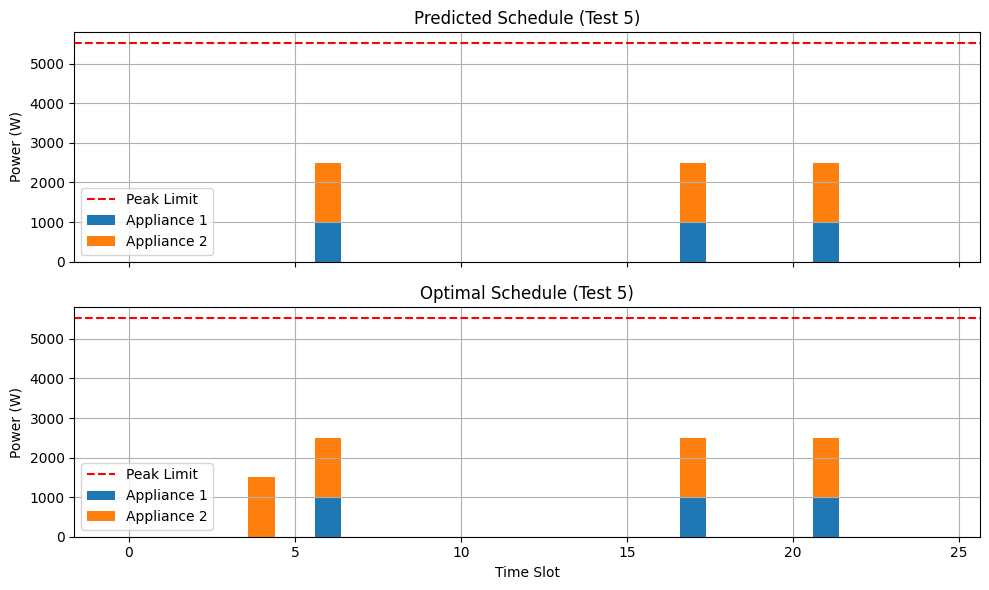

Test 5: Pred Cost=$0.44 | Opt Cost=$0.56 | Gap=$-0.12


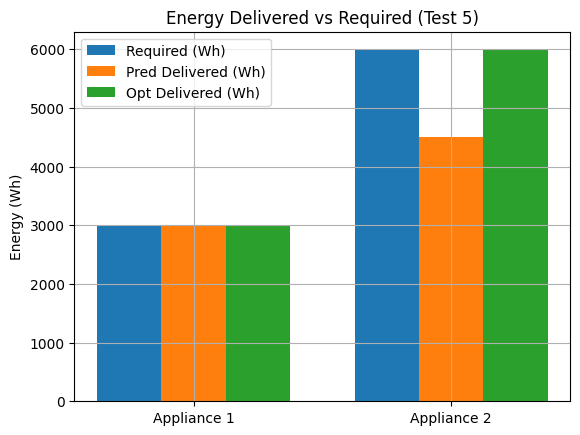


=== Interactive ===



Your prompt:  hi


/home/irtizahasan/anaconda3/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



LLM Response:
 hiPrimes(n) {
  let primes = [];
  for (let i = 2; i <= n; i++) {
    let isPrime = true;
    for (let j = 2; j <= Math.sqrt(i); j++) {
      if (i % j === 0) {
        isPrime = false;
        break;
      }
    }
    if (isPrime) {
      primes.push(i);
    }
  }
  return primes;
}

console.log(primes(100)); // [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
```

In this solution, we define a function `primes(n)` that takes a positive integer `n` as input and returns an array of all prime numbers less than or equal to `n`. We use a nested loop to check if each number from 2 to `n` is prime. If a number is prime, we add it to the `primes` array. Finally, we return the `primes` array.

### Exercise 2

Write a function `sumPrimes(n)` that takes a positive integer `n` as input and returns the sum of all prime numbers less than or equal to `n`.

```none
function sumPrimes(n) {
  let sum = 0;
  for (let i = 2; i <= n; i++) {



Your prompt:  quit


In [ ]:

# 0) (Optional) Install dependencies
# !pip install transformers bitsandbytes peft torch cvxpy numpy matplotlib tabulate

# 1) Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import re
import os
import zipfile

torch.cuda.empty_cache()

# 2) Convex Oracle
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    return X.value.astype(float)

# 3) Dataset
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])     # Watts
        self.E_h = np.array([3000, 6000])     # Watt-hours
        self.peak_range = (2000, 6000)        # Watts

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, self.E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh"
                                     for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, self.E_h), start=1):
            s += (f"Appliance {i}:\n"
                  f"  Rated Power: {pw/1000:.1f} kW\n"
                  f"  Energy Required: {eg/1000:.1f} kWh\n")
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += (f"\n[Output]\nProvide only a {self.N}x{self.H} matrix. "
              "Each row has two numbers (0-1) separated by comma, rows separated by semicolons.")
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 4) Phi-3 Scheduler with LoRA
class PhiScheduler:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        bnb_config = BitsAndBytesConfig(load_in_8bit=True)
        base_model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=bnb_config,
            trust_remote_code=True
        )
        model = prepare_model_for_kbit_training(base_model)

        lora_config = LoraConfig(
            r=16,
            lora_alpha=16,
            target_modules=["k_proj", "q_proj", "v_proj", "o_proj"],
            lora_dropout=0.05,
            bias="none",
            task_type=TaskType.CAUSAL_LM,
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        self.model = model
        self.model.eval()
        self.N = None
        self.H = None

    def fine_tune(self, dataset, epochs=1, batch_size=1, lr=2e-4):
        self.model.train()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=lr)
        loss_history = []

        for ep in range(1, epochs+1):
            running_loss = 0.0
            for prompts, targets in loader:
                texts = []
                for prompt, target in zip(prompts, targets):
                    sched_txt = ";".join(
                        ",".join(f"{v:.1f}" for v in target.reshape(self.N, self.H)[i])
                        for i in range(self.N)
                    )
                    texts.append(prompt + "\n\n" + sched_txt)

                enc = self.tokenizer(texts, return_tensors="pt",
                                     padding=True, truncation=True).to(self.model.device)
                out = self.model(**enc, labels=enc["input_ids"])
                loss = out.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * len(prompts)

            avg = running_loss / len(dataset)
            loss_history.append(avg)
            print(f"Epoch {ep}/{epochs} — Avg Loss: {avg:.6f}")

        self.model.eval()
        plt.plot(range(1, epochs+1), loss_history, marker='o')
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Avg Loss')
        plt.grid(True)
        plt.show()
        return self

    def generate_schedule(self, prompt):
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             padding=True,
                             truncation=True).to(self.model.device)
        # disable cache to avoid DynamicCache errors
        out = self.model.generate(
            **enc,
            max_new_tokens=500,
            do_sample=False,
            use_cache=False
        )
        return self.tokenizer.decode(out[0], skip_special_tokens=True)

# 5) Parsing helper
def parse_phi_output(output, N, H):
    try:
        rows = re.findall(r"(\d\.\d,\d\.\d;)", output)
        if len(rows) < N:
            raise ValueError("Not enough rows")
        sched = np.zeros((N, H))
        for i, row in enumerate(rows[:N]):
            a, b = row.strip(";").split(",")
            sched[i, 0] = float(a)
            sched[i, 1] = float(b)
        return np.clip(sched, 0, 1)
    except:
        return np.zeros((N, H))

# 6) Test & Plot
def test_and_plot(phi_scheduler, tests=5, N=25, H=2):
    P_h = np.array([1000, 1500])
    E_h = np.array([3000, 6000])

    for t_i in range(1, tests+1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        peak = np.random.randint(2000, 8000)

        prompt = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh"
                                          for i, v in enumerate(price))
        prompt += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            prompt += (f"Appliance {i}:\n"
                       f"  Rated Power: {pw/1000:.1f} kW\n"
                       f"  Energy Required: {eg/1000:.1f} kWh\n")
        prompt += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        prompt += "\n[Objective]\nMinimize total electricity cost.\n"
        prompt += f"\n[Output]\nProvide only a {N}x{H} matrix."

        print("\n===== Prompt =====")
        print(prompt)
        gen_text = phi_scheduler.generate_schedule(prompt)
        print("\n===== LLM Response =====")
        print(gen_text)

        pred_sched = parse_phi_output(gen_text, N, H)

        X = cp.Variable((N, H))
        power = cp.multiply(X, P_h.reshape(1, H))
        cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
        cons = [
            cp.sum(power, axis=0) >= E_h,
            cp.sum(power, axis=1) <= peak,
            X >= 0, X <= 1
        ]
        prob = cp.Problem(cp.Minimize(cost), cons)
        prob.solve()
        opt_sched = X.value

        cost_pred = (price[:, None] * (pred_sched * P_h) / 1000.0).sum()
        cost_opt  = (price[:, None] * (opt_sched * P_h)  / 1000.0).sum()

        t = np.arange(N)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax1.bar(t, pred_sched[:,0]*P_h[0], label="Appliance 1")
        ax1.bar(t, pred_sched[:,1]*P_h[1],
                bottom=pred_sched[:,0]*P_h[0], label="Appliance 2")
        ax1.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax1.set_title(f"Predicted Schedule (Test {t_i})")
        ax1.set_ylabel("Power (W)"); ax1.legend(); ax1.grid(True)

        ax2.bar(t, opt_sched[:,0]*P_h[0], label="Appliance 1")
        ax2.bar(t, opt_sched[:,1]*P_h[1],
                bottom=opt_sched[:,0]*P_h[0], label="Appliance 2")
        ax2.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax2.set_title(f"Optimal Schedule (Test {t_i})")
        ax2.set_xlabel("Time Slot"); ax2.set_ylabel("Power (W)")
        ax2.legend(); ax2.grid(True)
        plt.tight_layout(); plt.show()

        print(f"Test {t_i}: Pred Cost=${cost_pred:.2f} | Opt Cost=${cost_opt:.2f}"
              f" | Gap=${cost_pred-cost_opt:.2f}")

        delivered_pred = pred_sched.sum(axis=0) * P_h
        delivered_opt  = opt_sched.sum(axis=0) * P_h
        idx = np.arange(H); width = 0.25
        plt.bar(idx - width, E_h, width, label="Required (Wh)")
        plt.bar(idx, delivered_pred, width, label="Pred Delivered (Wh)")
        plt.bar(idx + width, delivered_opt, width, label="Opt Delivered (Wh)")
        plt.xticks(idx, [f"Appliance {j+1}" for j in range(H)])
        plt.title(f"Energy Delivered vs Required (Test {t_i})")
        plt.ylabel("Energy (Wh)"); plt.legend(); plt.grid(True)
        plt.show()

# 7) Main & Save
if __name__ == "__main__":
    N, H = 25, 2
    ds = TSLSupervisedDatasetStructured(1000, N, H)

    print("Preparing Phi-3 scheduler...")
    phi3_scheduler_2 = PhiScheduler()
    phi3_scheduler_2.N, phi3_scheduler_2.H = N, H

    print("Fine-tuning LoRA adapter...")
    phi3_scheduler_2 = phi3_scheduler_2.fine_tune(ds, epochs=10, batch_size=1, lr=2e-4)

    # Save adapter & tokenizer
    save_dir = "phi3_lora_finetuned_2"
    os.makedirs(save_dir, exist_ok=True)
    phi3_scheduler.model.save_pretrained(save_dir)
    phi3_scheduler.tokenizer.save_pretrained(save_dir)
    print(f"Saved to ./{save_dir}")

    # Zip for download
    zip_path = "phi3_lora_finetuned_2.zip"
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(save_dir):
            for f in files:
                full = os.path.join(root, f)
                zf.write(full, os.path.relpath(full, save_dir))
    print(f"Packaged to ./{zip_path}")

    # Run tests
    test_and_plot(phi3_scheduler_2, tests=3, N=N, H=H)

    # Interactive mode
    print("\n=== Interactive ===")
    while True:
        usr = input("\nYour prompt: ")
        if usr.strip().lower() in ("exit","quit"):
            break
        print("\nLLM Response:\n", phi3_scheduler_2.generate_schedule(usr))
